In [ ]:
#!pip install opencv-python numpy datasets matplotlib

# Building Color Histograms

To build our histograms we will be relying primarily on the OpenCV and Numpy libraries.

* **OpenCV** is a popular **C**omputer **V**ision (CV) library, it's full of useful image load/save and manipulation functions.
* **NumPy** is a very popular library focused on providing optimized numerical operations for multi-dimensional arrays.

Let's get a set of images, we will use the `pinecone/image-set` dataset from HuggingFace datasets:

In [ ]:
from datasets import load_dataset

data = load_dataset('pinecone/image-set', split='train', revision='e7d39fc')
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image_bytes', 'image'],
    num_rows: 21
})

Inside the *image_bytes* feature we have base64 encoded bytes representation of the images, we can decode them into Numpy arrays using the Open-CV library like so:

In [ ]:
from base64 import b64decode
import cv2
import numpy as np

def process_fn(sample):
    image_bytes = b64decode(sample['image_bytes'])
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    return image

images = [process_fn(sample) for sample in data]

We can display images with matplotlib.

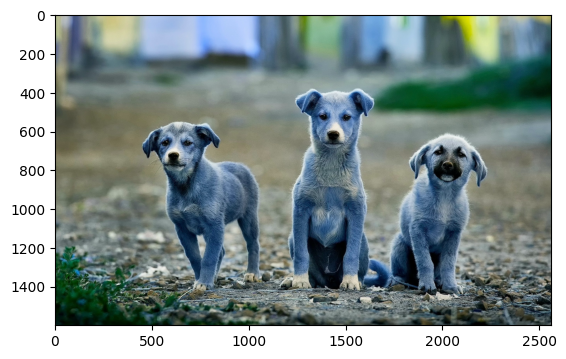

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[0])

OpenCV loads images in a **B**lue **G**reen **R**ed (BGR) format, Matplotlib expects RGB, so we invert to get the true color image like so:

In [ ]:
shape = images[0].shape
shape, images[0][0, 0, :]

((1600, 2560, 3), array([165, 174, 134], dtype=uint8))

In [ ]:
import numpy as np

rgb_image = np.flip(images[0], 2)

shape = rgb_image.shape
shape, rgb_image[0, 0, :]

((1600, 2560, 3), array([134, 174, 165], dtype=uint8))

Note that while the `shape` of the array has remained the same, the three values have been reversed (those three values are the BGR -> RGB values for a single pixel in the images).

Now we can visualize in real color.

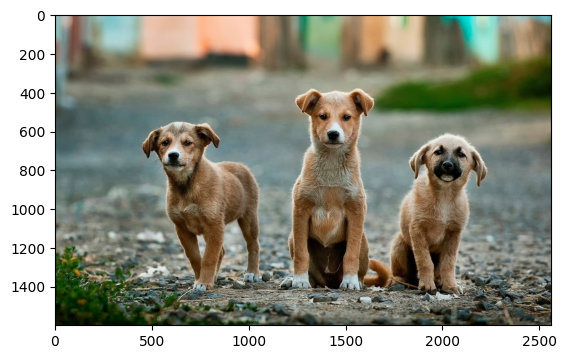

In [ ]:
plt.imshow(rgb_image)

## Building a Histogram the Slow Way

We'll start by building a color histogram the slow way so we can understand what is actually happening.

Let's take a look at image `0`, pixel `0`:

In [ ]:
images[0][0, 0, :]

array([165, 174, 134], dtype=uint8)

Each pixel has a **B**lue, **G**reen, and **R**ed activation value on a scale from `0` (no color) to `255` (max color).

We can see this by plotting the following colors by simply modifying the RGB values (remember they are inverted from BGR to RGB between OpenCV and Matplotlib):

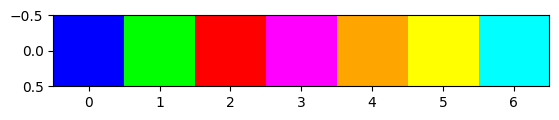

In [ ]:
blue = [0, 0, 255]
green = [0, 255, 0]
red = [255, 0, 0]
violet = [255, 0, 255]
orange = [255, 165, 0]
yellow = [255, 255, 0]
cyan = [0, 255, 255]

colors = np.asarray([[blue, green, red, violet, orange, yellow, cyan]])

plt.imshow(colors)

From these numbers:

| Blue | Green | Red |
| --- | --- | --- |
| 165 | 174 | 134 |

We can estimate that the first pixel will be a slight blue-green color (as these both overpower the red value, albeit slightly). We can see the pixel here in the top-left corner:

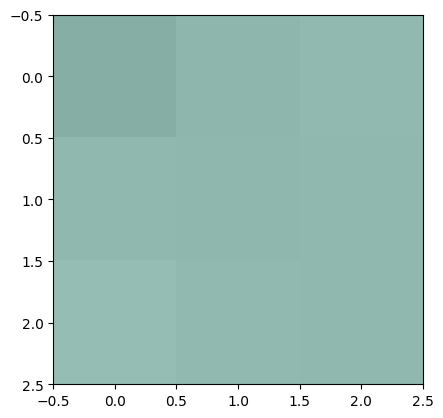

In [ ]:
plt.imshow(rgb_image[:3, :3, :])

We can plot these RGB values for each image across all pixels, moving from left-right and top-bottom. But to do this we need to transform the image array into a vector (one vector per color channel, RGB).

In [ ]:
image_vector = rgb_image.reshape(1, -1, 3)
image_vector.shape

(1, 4096000, 3)

We can still see the top left three pixels are the same:

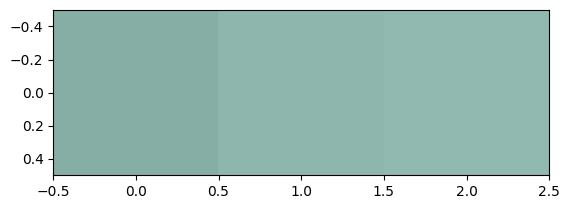

In [ ]:
plt.imshow(image_vector[:, :3, :])

We can split the values into their respective color channels:

In [ ]:
red = image_vector[0, :, 0]
green = image_vector[0, :, 1]
blue = image_vector[0, :, 2]

red.shape, green.shape, blue.shape

((4096000,), (4096000,), (4096000,))

Now visualize each with a histogram.

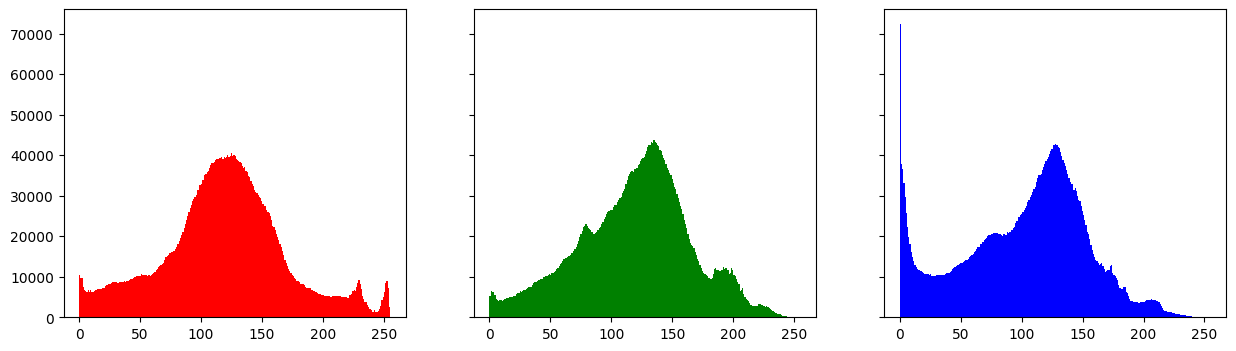

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].hist(red, bins=256, color='r')
axs[1].hist(green, bins=256, color='g')
axs[2].hist(blue, bins=256, color='b')
plt.show()

Here we can see the three color channels, on the x-axis we have the pixel color value (from *0 -> 255*) and on the y-axis we see the total number of pixels with that color value.

Let's put everything we've done so far into a single function so we can replicate these charts for a few images.

In [ ]:
def build_histogram(image, bins=256):
    # convert from BGR to RGB
    rgb_image = np.flip(image, 2)
    # show the image
    plt.imshow(rgb_image)
    # convert to a vector
    image_vector = rgb_image.reshape(1, -1, 3)
    # break into given number of bins
    div = 256 / bins
    bins_vector = (image_vector / div).astype(int)
    # get the red, green, and blue channels
    red = bins_vector[0, :, 0]
    green = bins_vector[0, :, 1]
    blue = bins_vector[0, :, 2]
    # build the histograms
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    axs[0].hist(red, bins=bins, color='r')
    axs[1].hist(green, bins=bins, color='g')
    axs[2].hist(blue, bins=bins, color='b')
    plt.show()

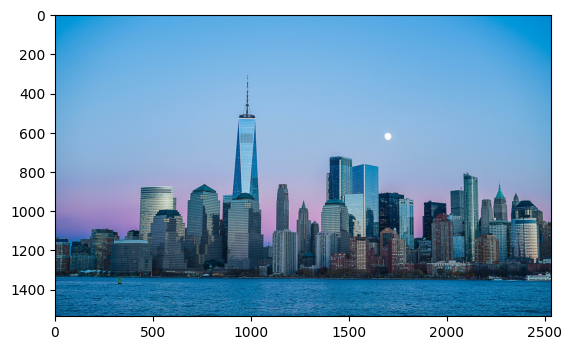

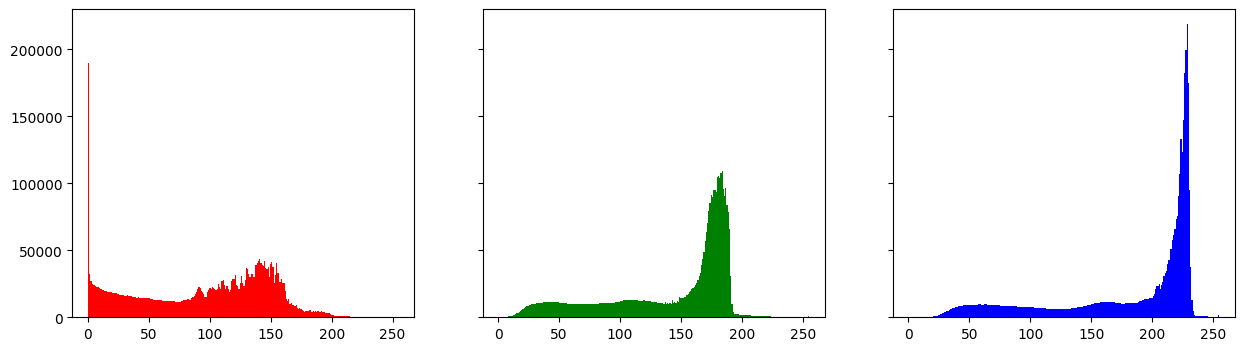

In [ ]:
# we will see a lot of blue in this image, and it shows
# as high counts in high values in the blue histogram
build_histogram(images[1])

One thing I added to this formula is the option to reduce the number of bins we are visualizing, eg rather than visualize every color value (0 -> 255) as a single bar, we can visualize values [0-4, 5-9, 10-14, ...] together using the `bins` parameter.

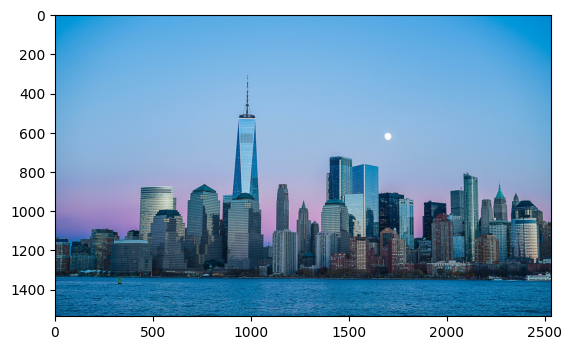

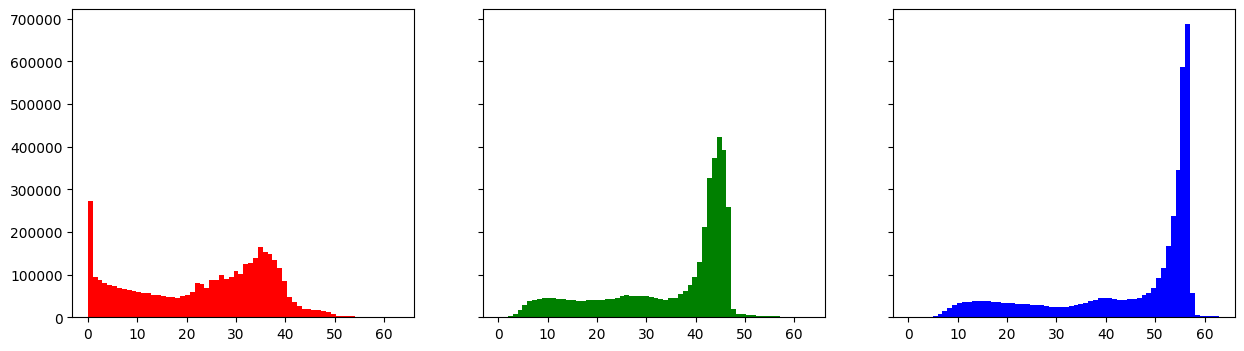

In [ ]:
build_histogram(images[1], 64)

This can be great for reducing the size of our image representations while still keeping as much information as possible.

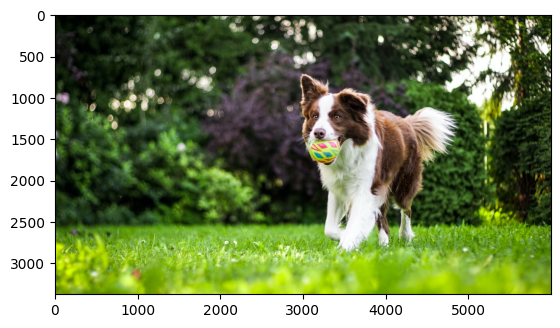

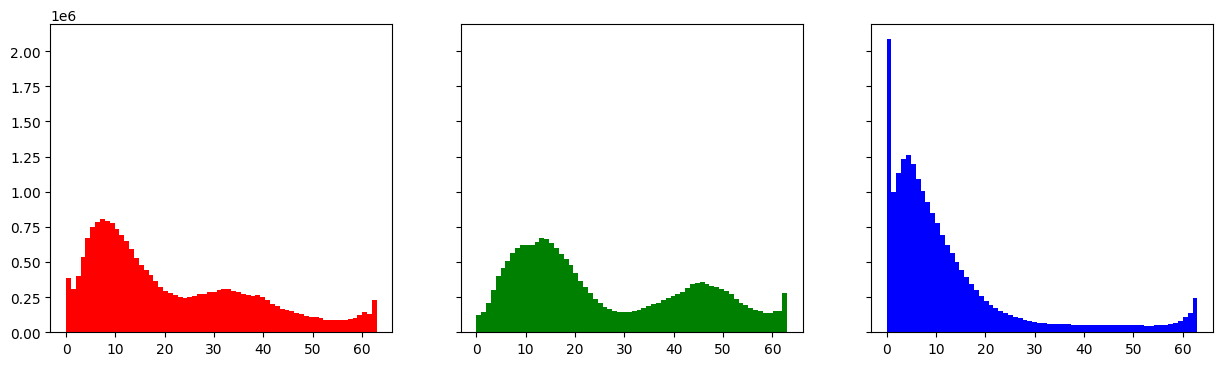

In [ ]:
# very little blue in this image, and it shows as high counts in *low* values
# of the blue histogram
build_histogram(images[2], 64)

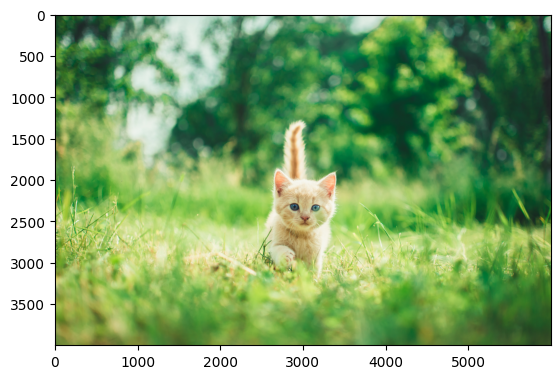

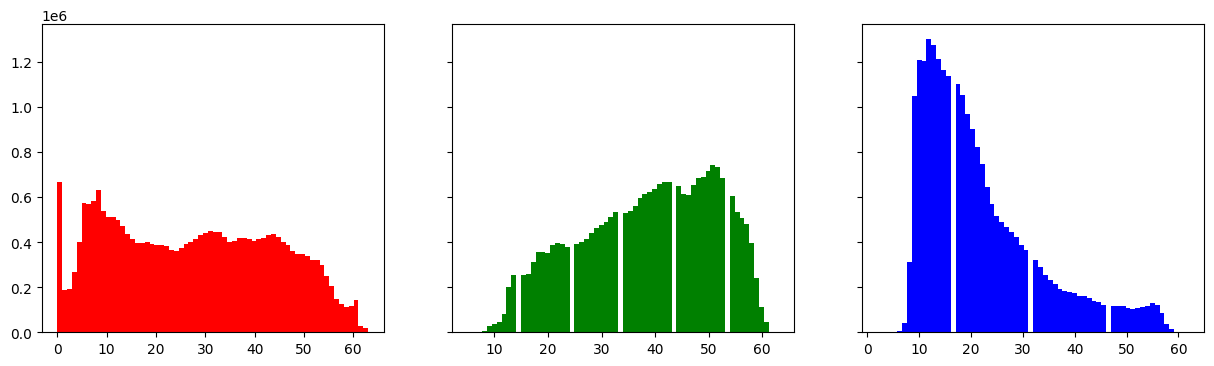

In [ ]:
# blue again is very low, plenty of green
build_histogram(images[3], 64)

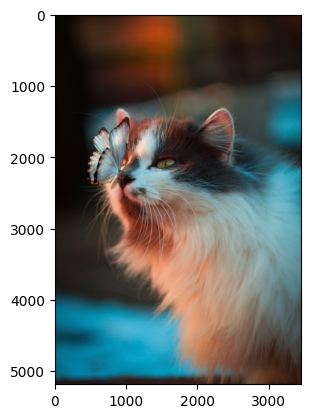

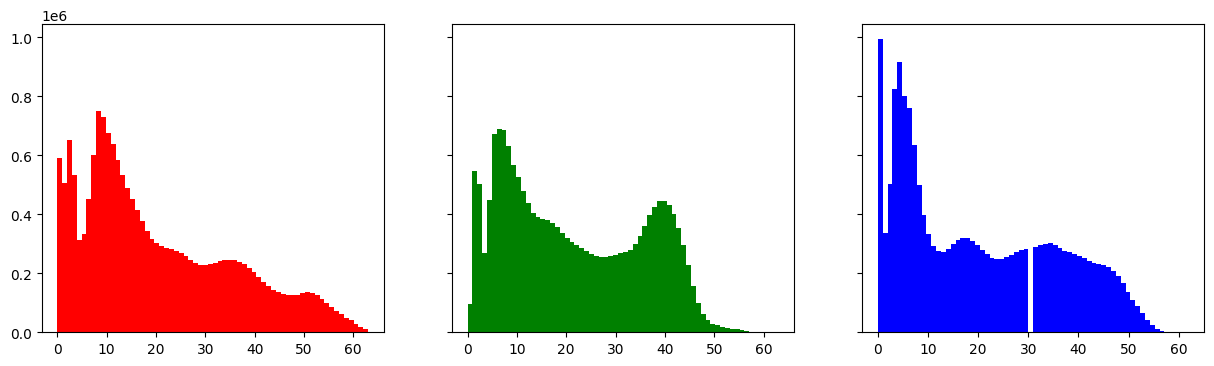

In [ ]:
build_histogram(images[4], 64)

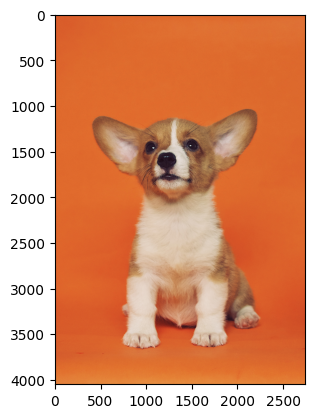

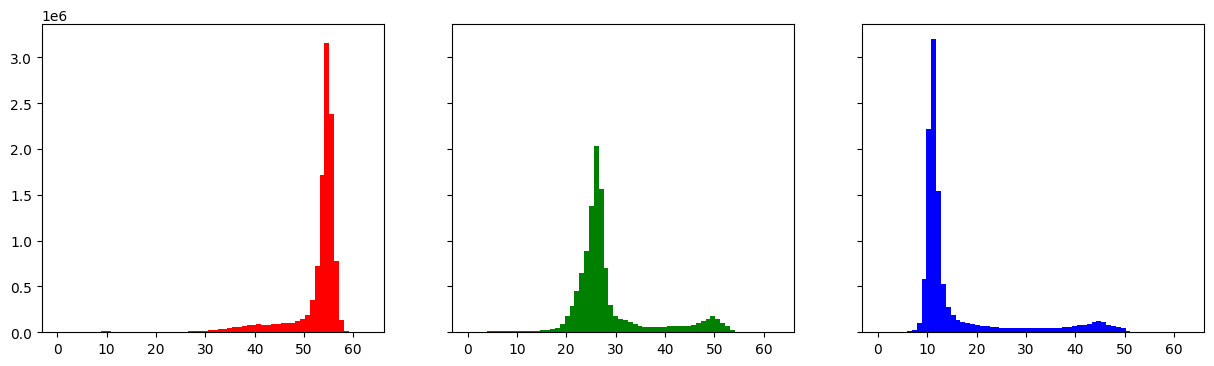

In [ ]:
build_histogram(images[5], 64)

Okay so that is the *slow way* of building histograms, hopefully it's very clear how this works. But how can we do this more efficiently?

The open-cv library which we have already imported as `cv2` actually has a function specifically built for calculating histograms called `calcHist`, it looks like this:

In [ ]:
red_hist = cv2.calcHist([images[5]], [2], None, [64], [0, 256])
green_hist = cv2.calcHist([images[5]], [1], None, [64], [0, 256])
blue_hist = cv2.calcHist([images[5]], [0], None, [64], [0, 256])

red_hist.shape

(64, 1)

In [ ]:
help(cv2.calcHist)

Help on built-in function calcHist:

calcHist(...)
    calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) -> hist
    .   @overload
    .   
    .   this variant supports only uniform histograms.
    .   
    .   ranges argument is either empty vector or a flattened vector of histSize.size()*2 elements
    .   (histSize.size() element pairs). The first and second elements of each pair specify the lower and
    .   upper boundaries.



The values used here are:

```
cv2.calcHist([images], [channels], [mask], [bins], [hist_range])
```

Where:
* `images` is our cv2 loaded image with channels blue, green, red. This argument expects a list of images which is why we have placed our single image inside square brackets `[]`.
* `channels` is the color channel (BGR) that we'd like to create a histogram for. We do this for a single channel at once.
* `mask` is another image (or list of images) consisting of `0` and `1` values that allow us to *mask* part of the `images` if wanted, we don't want to do this so we set it to `None`.
* `bins` is as before, the number of bins/ranges that we want to place our values in. We can set this to `256` if we'd like to keep the original values.
* `hist_range` is the range of color values we would expect. As we're using RGB we expect a min value of `0` and max value of `255`, so we write `[0, 256]` (the upper limit is exclusive, not inclusive).

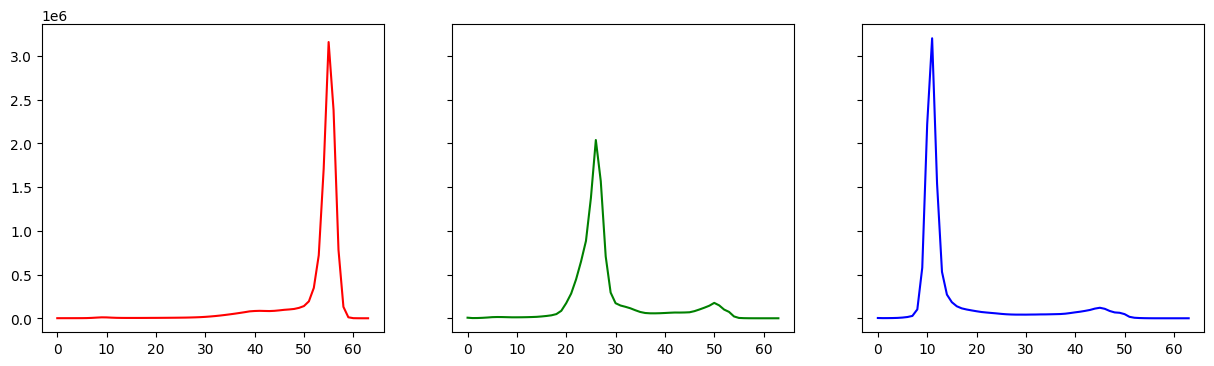

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].plot(red_hist, color='r')
axs[1].plot(green_hist, color='g')
axs[2].plot(blue_hist, color='b')
plt.show()

---